<h1>Projket ekonometrtia</h1>
<h2>Uczelnia itd</h2>
<h2>Mateusz Jakubczak</h2>


Cytowania 

@inproceedings{seabold2010statsmodels,
  title={statsmodels: Econometric and statistical modeling with python},
  author={Seabold, Skipper and Perktold, Josef},
  booktitle={9th Python in Science Conference},
  year={2010},
}



<h3>Abstrakt cell projektu, hipoteza badawcza 



<h3>Pobieranie danych


In [19]:
import requests
from bs4 import BeautifulSoup
import re
import csv
import os
import unicodecsv
import pandas as pd

In [20]:
#pare zmiennych globalnych 


with open("linki.csv",newline="") as csvfile:
    reader = csv.reader(csvfile)
    links2 = list(reader)
 
links =  [item for sublist in links2[1:] for item in sublist]

znaczniki ={"Cena":"_1svub _lf05o _9a071_2MEB_"}

lista_parametrów = ["Cena","Stan","Typ telewizora","Marka",
                    "Technologia 3D", "Przekątna ekranu",
                    "Format HD","Rozdzielczość ekranu",
                    "Liczba złączy HDMI", "Technologia HDR",
                    "Klasa efektywności","Pobór mocy",
                    "Waga produktu"
                    ]


#with open(os.path.join(os.getcwd(), 'parametry.csv'), 'wb') as csvfile:
 #   writer = unicodecsv.DictWriter(csvfile, fieldnames = lista_parametrów , delimiter = ';')
  #  writer.writeheader()
    

In [ ]:
for link in links:
    parmaetry = []
    response = requests.get(link)
   # print(response)
    
    # znalazeinei ceny 
    soup = BeautifulSoup(response.content,'html.parser')
    #nalezalo by zastapic lepszym wyszukaniem
    try:
        cena = soup.find(class_=znaczniki["Cena"] )
        # przejsc do dolu dwa razy po pierwszym elemencie 
        cena = cena.contents[0].contents[0]
    except:
        AttributeError
        print(link)
        continue
    parmaetry.append(cena)
    #zanjdowanie tabeli parametrow 
    pattern = re.compile(r'Parametry')
    tabela = soup.find("h2",text= pattern)
    #do gory dwa poziomy 
    tabela = tabela.parent.parent
   
    for param in lista_parametrów[1:]:
        try:
            #najpier znajdz czy jest pole ktore nazywa sie dokladnie tak
            stan_field = tabela.find(text = param)
            #jesli nie ma takiego pola znajdz pierwsze które nazywa sie podobnie
            if stan_field == None:  stan_field = tabela.find(text = re.compile(rf"{param}"))
            #jesli nie znalioziona to wpisac -1
            if stan_field == None: stan_field = -1
            #up two nodes in tree then select content of second one
            stan_field = stan_field.parent.parent.contents[1].contents[0]
            try:
                if stan_field.contents != None : stan_field = stan_field.contents[0]
            except:
                AttributeError   #dla pól co zawieraja w sobie linka 
        except:
            AttributeError 
            print(f"Nie ma takiego parametru, parametr {param}") 
            stan_field = -1
        parmaetry.append(stan_field)
    with open('parametry.csv', 'ab') as csvfile:
        writer = unicodecsv.DictWriter(csvfile, fieldnames = lista_parametrów , delimiter = ';')
        writer.writerow(dict(zip(lista_parametrów,parmaetry)))

<h3>Staystyki opisowe

In [21]:
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [99]:
from pandas_profiling import ProfileReport
df = pd.read_csv("parametry.csv",delimiter=";")
df.dtypes
#Cleaning



df["Cena"] = df["Cena"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Cena"] = df["Cena"].apply(pd.to_numeric)


#dla technoligi 3d w przypdako brakow zakladmy ze nie 



df["Technologia 3D"] = df["Technologia 3D"].apply(lambda s : "nie" if s != "tak" else s)
df["Technologia 3D"] = df["Technologia 3D"].map({'tak': True, 'nie': False})
df["Technologia 3D"] = df["Technologia 3D"].convert_dtypes()
#print(df["Technologia 3D"] )
#zmeinic przekonte na int

#

df["Przekątna ekranu"] = df["Przekątna ekranu"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Przekątna ekranu"] = df["Przekątna ekranu"].apply(pd.to_numeric)
#print(df["Przekątna ekranu"] )
#polaczyc rozdzielczosc i format hd
#print(pd.crosstab(df["Rozdzielczość ekranu"],df["Format HD"]))
#print(cramers_v(df["Rozdzielczość ekranu"],df["Format HD"]))
#jak widac na macierzy korelacji i co potwierdza mienik korelacji v-cramera
#rozdzielczosc i format hd sa silnie skolerowane, dlatego podam te dwie zmienne tranforamcji w jedna 



slownik = {'3840 x 2160': '4K UHD',
 '7680 x 4320': '8K UHD',
 '1920 x 1080': 'Full HD',
 '1366 x 768': 'HD Ready'}

df['jakosc'] = df[[ 'Format HD','Rozdzielczość ekranu']].agg(';'.join, axis=1)

df['jakosc'] = df['jakosc'].apply(
    lambda s: s.split(sep = ";")[0] if s.split(sep = ";")[0] != "-1" and s.split(sep = ";")[0] != "inny"
    else slownik[s.split(sep = ";")[1]])

df["jakosc"]=df["jakosc"].astype('category')



#zmienic liczbe zleczy hdmi na categorical 
df["Liczba złączy HDMI"]=df["Liczba złączy HDMI"].astype('category')




#dla braku technologi HDR dac Nie 
df["Technologia HDR"] =df["Technologia HDR"].apply(lambda s: s if s != "-1" else "Nie")
df["Technologia HDR"]=df["Technologia HDR"].astype('category')
df["Technologia HDR"].value_counts()

#klasy efektrywnosci -1 zamienic na inna 
df["Klasa efektywności"] = df["Klasa efektywności"].apply(lambda s: s if s != "-1" else "inna").astype("category")
df["Klasa efektywności"].value_counts()



#przeksztalcic pobor mocy do int 

df["Pobór mocy"] = df["Pobór mocy"].apply(lambda s :''.join([i for i in s if i.isdigit()]))
df["Pobór mocy"] = df["Pobór mocy"].apply(pd.to_numeric)



# drop wagi 
df.drop(["Waga produktu", "Rozdzielczość ekranu","Format HD"], axis=1 , inplace=True)


df["Stan"] = df["Stan"].astype('category')
df["Typ telewizora"] = df["Typ telewizora"].astype('category')


#marka dla malo papularne zastapic inna 
count = df["Marka"].value_counts()
popular = count > count.mean()
df["Marka"] = df["Marka"].apply(lambda row: row if popular[row] else "inna").astype("category")
df["Marka"].value_counts()


Samsung        28
inna           20
LG             15
Sony            6
Philips         6
Kruger&Matz     6
Name: Marka, dtype: int64

In [73]:
regresion_data = pd.get_dummies(df, drop_first=True)
#profile = ProfileReport(df,explorative=True)
#profile

In [100]:
df.loc[df["Klasa efektywności"] == "D"]

,Cena,Stan,Typ telewizora,Marka,Technologia 3D,Przekątna ekranu,Liczba złączy HDMI,Technologia HDR,Klasa efektywności,Pobór mocy,jakosc
80,24000,Nowy,QLED,Samsung,False,82,4,Tak,D,579,8K UHD


<h3>Macierz korelacji 



<h3>Model liniowy

In [102]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt



In [113]:
Y = regresion_data["Cena"]
Y = Y[:70]
X = regresion_data.iloc[:70,1:]
X = sm.add_constant(X).astype(float)

model = sm.OLS(Y,X)
result = model.fit()

result.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Cena   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     9.611
Date:                Sun, 07 Jun 2020   Prob (F-statistic):           1.03e-10
Time:                        01:16:10   Log-Likelihood:                -547.79
No. Observations:                  70   AIC:                             1152.
Df Residuals:                      42   BIC:                             1215.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -7636.5990   1785.942     -4.276      0.000   -1.12e+04   -4032.422
Technologia 3D            496.5176    602.201      0.825      0.414    -718.774    1711.809
Przekątna ekranu           91.3645     16.118      5.669      0.000      58.838     123.891
Pobór mocy                  6.2078      2.637      2.355      0.023       0.887      11.529
Stan_Po zwrocie          -523.5051    661.255     -0.792      0.433   -1857.972     810.962
Stan_Powystawowy         -860.3298    592.713     -1.452      0.154   -2056.473     335.814
Stan_Używany             -203.4281    320.501     -0.635      0.529    -850.224     443.368
Typ telewizora_LED        645.5176    476.026      1.356      0.182    -315.142    1606.177
Typ telewizora_OLED      1906.1140    964.099      1.977      0.055     -39.516    3851.744
Typ telewizora_QLED      1784.0796    728.517      2.449      0.019     313.874    3254.286
Typ telewizora_inny      2171.0318   1021.505      2.125      0.039     109.551    4232.512
Typ telewizora_plazmowy  -857.5962    838.030     -1.023      0.312   -2548.810     833.617
Marka_LG                 -225.7718    523.835     -0.431      0.669   -1282.914     831.371
Marka_Philips             187.1260    630.847      0.297      0.768   -1085.976    1460.228
Marka_Samsung             -64.8582    542.800     -0.119      0.905   -1160.273    1030.557
Marka_Sony               -304.7794    626.983     -0.486      0.629   -1570.082     960.523
Marka_inna                 65.6446    440.176      0.149      0.882    -822.666     953.955
Liczba złączy HDMI_1     5077.1176   1319.695      3.847      0.000    2413.866    7740.369
Liczba złączy HDMI_2     3788.8768   1198.986      3.160      0.003    1369.225    6208.528
Liczba złączy HDMI_3     3559.0794   1183.823      3.006      0.004    1170.027    5948.131
Liczba złączy HDMI_4     3767.2622   1261.668      2.986      0.005    1221.112    6313.412
Technologia HDR_Tak        73.8813    487.473      0.152      0.880    -909.879    1057.642
Klasa efektywności_A+    -268.6837    260.491     -1.031      0.308    -794.375     257.008
Klasa efektywności_B     -157.3050    736.701     -0.214      0.832   -1644.028    1329.417
Klasa efektywności_C       96.0602   1133.549      0.085      0.933   -2191.534    2383.654
Klasa efektywności_D     3.206e-14   8.07e-13      0.040      0.968    -1.6e-12    1.66e-12
Klasa efektywności_inna   128.2238    386.899      0.331      0.742    -652.569     909.017
jakosc_8K UHD                    0          0        nan        nan           0           0
jakosc_Full HD             60.7717    483.509      0.126      0.901    -914.988    1036.532
jakosc_HD Ready           689.4465    565.415      1.219      0.230    -451.607    1830.500
===============================================

<h3> Wstepna analiza modelu 

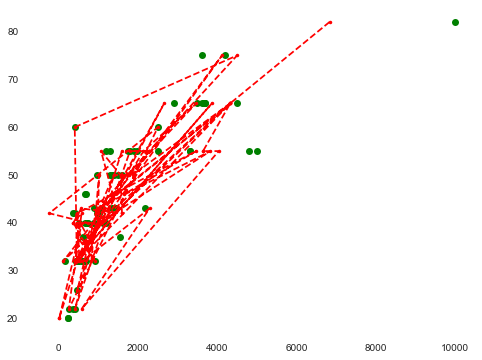

In [115]:
prstd, iv_l, iv_u = wls_prediction_std(result)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(Y, df["Przekątna ekranu"][:70], "go" )
ax.plot(result.fittedvalues,df["Przekątna ekranu"][:70], 'r--.')

<h3> Poprawki do modelu




<h3> Wybór modelu 


<h3>Testowanie Modelu oraz Pełny opis</h3>

*  Współczynnik determinacji.
*  Efekt katalizy.
*  Normalność rozkładu składnika losowego.
*  Istotność zmiennych.
*  Testy dodanych (pominiętych zmiennych).
*  Obserwacje odstające.
*  Test liczby serii (uporządkować obserwacje!!).
*  Test RESET.19.Testowanie heteroskeastyczności.
*  Test Chowa (wraz z komentarzem na temat podziału próbki na dwie grupy).
*  Współliniowość.
*  Koincydencja.
*  Interpretacja parametrów modelu (tam gdzie trzeba elastyczność).
*  redykcjawraz z 95% przedziałem ufności.
